In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.utils import shuffle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/Bangla_NLP/finalpuredataset.csv")
# dataset = pd.read_csv("finalbangladataset.csv")

Label:
*   1 => 'আনন্দ'
*   2 => 'বিষণ্ণতা'
*   3 => 'ভয়'
*   4 => 'রাগ'
*   5 => 'ভালবাসা'
*   6 => 'আশ্চর্য'  

In [ ]:
dataset.head()

,Text,Label
0,আমি অপমানিত বোধ করিনি,2
1,আমি যত্নবান এবং জাগ্রত এমন ব্যক্তির আশেপাশে থা...,2
2,আমার মনে হচ্ছে যে দুর্দশাগুলি আমি দেখতে পাচ্ছি...,2
3,আমি কম শক্তি অনুভব করছি আমি কেবল তৃষ্ণার্ত,2
4,আমি সত্যিই বিব্রত বোধ করিনি,2


In [ ]:
dataset = shuffle(dataset)

In [ ]:
train_size = int(len(dataset) * 0.8)

In [ ]:
train_text = dataset['Text'][:train_size]
train_label = dataset['Label'][:train_size]
test_text = dataset['Text'][train_size:]
test_label = dataset['Label'][train_size:]

In [ ]:
token = text.Tokenizer(num_words=15000,char_level=False)
token.fit_on_texts(train_text)
X_train = token.texts_to_matrix(train_text)

In [ ]:
# token = text.Tokenizer(num_words=15000,char_level=False)
# token.fit_on_texts(train_label)
# train_label_matrix = token.texts_to_matrix(train_label)

In [ ]:
token = text.Tokenizer(num_words=15000,char_level=False)
token.fit_on_texts(test_text)
X_test = token.texts_to_matrix(test_text)

In [ ]:
# token = text.Tokenizer(num_words=15000,char_level=False)
# token.fit_on_texts(test_label)
# test_label_matrix = token.texts_to_matrix(test_label)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5776, 15000)
(1445, 15000)


In [ ]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(train_label)
Y_test = encoder.fit_transform(test_label)

In [ ]:
num_classes = np.max(Y_train) + 1

In [ ]:
print(num_classes)

6


In [ ]:
print(Y_test)
print(Y_test.shape)
print(Y_train)
print(Y_train.shape)

[4 0 5 ... 5 3 5]
(1445,)
[4 3 4 ... 2 0 2]
(5776,)


In [ ]:
from keras import regularizers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense

model = Sequential()
model.add(Dense(512, input_shape=(15000,), activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train, batch_size=2, validation_split=0.33,epochs=50)

In [ ]:
score = model.evaluate(X_test, Y_test,
                       batch_size=2, verbose=1)
print('Test accuracy:', score)

723/723 [==============================] - 1s 2ms/step - loss: 3.6730 - accuracy: 0.1889
Test accuracy: [3.672961711883545, 0.18892733752727509]


Using **BERT**

In [ ]:

!pip install transformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 12.7MB/s 
     |████████████████████████████████| 890kB 16.7MB/s 
     |████████████████████████████████| 3.0MB 27.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ab4fe7ddd50e5cfd51060ebdbc969daf12298282ce6c672656a78af0725b8f67
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
% matplotlib inline

In [ ]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device("cuda")

In [ ]:
print(device)

cuda


In [ ]:
dataset['Label'].unique()

array([2, 4, 5, 6, 3, 1])

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# dataset['label_enc'] = labelencoder.fit_transform(dataset['Label'])

In [ ]:
# print(dataset['label_enc'])

In [ ]:
# dataset[['Label','label_enc']].drop_duplicates(keep='first')
# dataset.rename(columns={'Label':'label_desc'},inplace=True)
# dataset.rename(columns={'label_enc':'Label'},inplace=True)

In [ ]:
dataset

,Text,Label
0,আমি অপমানিত বোধ করিনি,2
1,আমি যত্নবান এবং জাগ্রত এমন ব্যক্তির আশেপাশে থা...,2
2,আমার মনে হচ্ছে যে দুর্দশাগুলি আমি দেখতে পাচ্ছি...,2
3,আমি কম শক্তি অনুভব করছি আমি কেবল তৃষ্ণার্ত,2
4,আমি সত্যিই বিব্রত বোধ করিনি,2
...,...,...
7216,আমি কিছুটা দুঃসাহসী বোধ করছি তাই দেখার চেষ্টা ...,1
7217,আমি বিভিন্ন বিতর্ক চলতে পেরে আনন্দিত বোধ করি ত...,1
7218,আপনি আমার আমন্ত্রণটি গ্রহণ করেছেন বলে আমি সম্ম...,1
7219,আমি প্রায়শই রঙিন কোড থেকে নীল এস এর মতো নৈমিত...,1


In [ ]:
## create label and sentence list
sentences = dataset.Text.values

In [ ]:
print(sentences)

['আমি অপমানিত বোধ করিনি'
 'আমি যত্নবান এবং জাগ্রত এমন ব্যক্তির আশেপাশে থাকা থেকে আমি এতটাই আশাহত বোধ থেকে বিরত থাকতে পারি'
 'আমার মনে হচ্ছে যে দুর্দশাগুলি আমি দেখতে পাচ্ছি তা বোঝাতে চাই' ...
 'আপনি আমার আমন্ত্রণটি গ্রহণ করেছেন বলে আমি সম্মানিত বোধ করছি'
 'আমি প্রায়শই রঙিন কোড থেকে নীল এস এর মতো নৈমিত্তিক কথোপকথনেও যে কোনও বিষয়ে রক্ষা করার প্রয়োজন বোধ করি সাধারণত ক্রিসমাসের ধর্মান্ধ এবং আমি ঝাঁপিয়ে পড়ে এবং'
 'আমি খুব সুন্দর এবং গ্ল্যামারাস বোধ করি']


In [ ]:
#check distribution of data based on labels
print("Distribution of data based on labels: ",dataset.Label.value_counts())

Distribution of data based on labels:  3    1399
4    1376
1    1362
2    1352
5    1199
6     533
Name: Label, dtype: int64


In [ ]:
MAX_LEN = 512

In [ ]:
## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=False)
# input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]

In [ ]:
print(tokenizer)

In [ ]:
input_ids = [tokenizer.encode(sent, add_special_tokens=True,truncation=True,pad_to_max_length=True, max_length=100) for sent in sentences]

In [ ]:
print(input_ids)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
labels = dataset.Label.values

In [ ]:
print(labels)

[2 2 2 ... 1 1 1]


In [ ]:
print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

Actual sentence before tokenization:  আমার মনে হচ্ছে যে দুর্দশাগুলি আমি দেখতে পাচ্ছি তা বোঝাতে চাই
Encoded Input from dataset:  [101, 1348, 29906, 29914, 29908, 1370, 29902, 29917, 100, 1371, 29917, 100, 1348, 29906, 29915, 1364, 29917, 29890, 29898, 29917, 100, 1362, 29914, 100, 1356, 29914, 29885, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:

train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [ ]:
print(train_inputs)
print(len(train_inputs))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
print(len(train_labels))
print(len(train_inputs))
print(len(train_masks))

6498
6498
6498


In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [ ]:
train_data[0]

(tensor([  101,  1348, 29906, 29915,   100,   100,  1353, 29908, 29893, 29915,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
print(len(train_dataloader))

204


In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)

# Parameters:
lr = 2e-5
adam_epsilon = 1e-8

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

num_warmup_steps = 0
# num_training_steps = len(train_dataloader)*epochs
num_training_steps = 5*epochs

### In Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# print((b_labels))

In [ ]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around the normal python range
for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    print( step)
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]

    # Backward pass
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()

    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])

  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})

    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)

    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1
    print("eval : ", tmp_eval_accuracy)

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


<====================== Epoch 1 ======================>
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [ ]:
!nvidia-smi

Sun Aug 23 18:26:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

***USING GRU***

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras import models
# from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/My Drive/Bangla_NLP/'

In [ ]:
# txt_file = open(path+"train.txt","r")
# data = pd.read_csv(path+'finalpuredataset.csv',encoding='utf-8')
# f = txt_file.readlines()
# print(f)
# import csv
# with open(path+'finalpuredataset_29_8.csv', 'w', newline='') as file:
#   writer = csv.writer(file)
#   writer.writerow(["Text", "Label"])
#   for line in f:
#     splitted_data = line.split(' ',1)
#     if(splitted_data[0] == "surprise"):
#       print(splitted_data)
#       writer.writerow([splitted_data[1], 6])

#   for ind in data.index:
#     #  print(data['Text'][ind], data['Label'][ind])
#      writer.writerow([data['Text'][ind], data['Label'][ind]])


Total number of Emotion: 7221


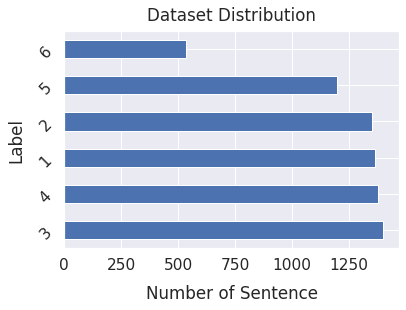

In [ ]:
data = pd.read_csv(path+'finalpuredataset.csv',encoding='utf-8')
# data = pd.read_csv('finalbangladataset.csv',encoding='utf-8')
data = data.sample(frac=1)
# data = data.drop(data[data.Label == 5].index)
print(f'Total number of Emotion: {len(data)}')
sns.set(font_scale=1.4)
data['Label'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Sentence", labelpad=12)
plt.ylabel("Label", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:

data.columns

Index(['Text', 'Label'], dtype='object')

In [ ]:

# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return headlines
# Apply the function into the dataframe
data['cleaned'] = data['Text'].apply(cleaning_data)

# print some cleaned reviews from the dataset
sample_data = [200,500,1000,1500,3000,3500]
for i in sample_data:
  print('Original: ',data.Text[i],'\nCleaned:',
           data.cleaned[i],'\n','Lebel:-- ',data.Label[i],'\n')

Original:  আমি মনে করি যে পরিচালক সম্পাদক একটি শিক্ষণীয় মুহুর্তটি মিস করেছেন যখন টিফানি তার মন্তব্যগুলি সবার মতো অনুভব করার মতো সুন্দর লাগছে 
Cleaned: আমি মনে করি যে পরিচালক সম্পাদক একটি শিক্ষণীয় মুহুর্তটি মিস করেছেন যখন টিফানি তার মন্তব্যগুলি সবার মতো অনুভব করার মতো সুন্দর লাগছে 
 Lebel:--  2 

Original:  আমি আশা করি কেউই নিজেকে অকৃতজ্ঞ বোধ করবেন না কারণ এটি মামলা নয় 
Cleaned: আমি আশা করি কেউই নিজেকে অকৃতজ্ঞ বোধ করবেন না কারণ এটি মামলা নয় 
 Lebel:--  2 

Original:  আমি এখনই খুব অসন্তুষ্ট বোধ করছি 
Cleaned: আমি এখনই খুব অসন্তুষ্ট বোধ করছি 
 Lebel:--  2 

Original:  আমি এমন কিছু জিনিস দেখেছি যা চলচ্চিত্রের অভিযোজনের জন্য আমি নিজেই কখনও করতে পারতাম না তবে অনুভব করি যে আমি যদি বইটি না পড়ি তবে তা আমাকে বিরক্ত করবে না 
Cleaned: আমি এমন কিছু জিনিস দেখেছি যা চলচ্চিত্রের অভিযোজনের জন্য আমি নিজেই কখনও করতে পারতাম না তবে অনুভব করি যে আমি যদি বইটি না পড়ি তবে তা আমাকে বিরক্ত করবে না 
 Lebel:--  4 

Original:  আমি গরম কোকো এবং ফ্ল্যানেল নাইটস এর আরামদায়ক অনুভূতির জন্য কৃতজ্ঞ 
Cleaned: আমি গর

In [ ]:
# Length of each headlines
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Emotion Data".format(len(data)-len(dataset)),
      "\nTotal Emotion Data:",len(dataset))

After Cleaning: 
Removed 7 Small Emotion Data 
Total Emotion Data: 7214


In [ ]:
def data_summary(dataset):

    """
    This function will print the summary of the headlines and words distribution in the dataset.

    Args:
        dataset: list of cleaned sentences

    Returns:
        Number of documnets per class: int
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Label.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.Label==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Label==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)


Class Name :  3
Number of Documents:1395
Number of Words:24826
Number of Unique Words:4093
Most Frequent Words:

আমি	2115
বোধ	803
এবং	728
করি	660
আমার	621
যে	419
করছি	382
না	374
করতে	300
অনুভব	279

Class Name :  4
Number of Documents:1373
Number of Words:25152
Number of Unique Words:4145
Most Frequent Words:

আমি	2095
এবং	739
আমার	715
করি	703
বোধ	673
যে	498
না	428
অনুভব	373
করছি	332
মনে	312

Class Name :  1
Number of Documents:1362
Number of Words:25017
Number of Unique Words:4360
Most Frequent Words:

আমি	2024
এবং	811
করি	771
বোধ	661
আমার	631
যে	459
মনে	371
না	317
অনুভব	308
করতে	287

Class Name :  2
Number of Documents:1352
Number of Words:24255
Number of Unique Words:4033
Most Frequent Words:

আমি	2071
এবং	771
করি	709
আমার	697
বোধ	667
যে	426
না	396
অনুভব	346
মনে	313
করছি	300

Class Name :  5
Number of Documents:1199
Number of Words:22884
Number of Unique Words:3995
Most Frequent Words:

আমি	1771
এবং	785
আমার	691
করি	661
যে	436
অনুভব	433
বোধ	385
না	304
মনে	302
করতে	240

Class Name : 

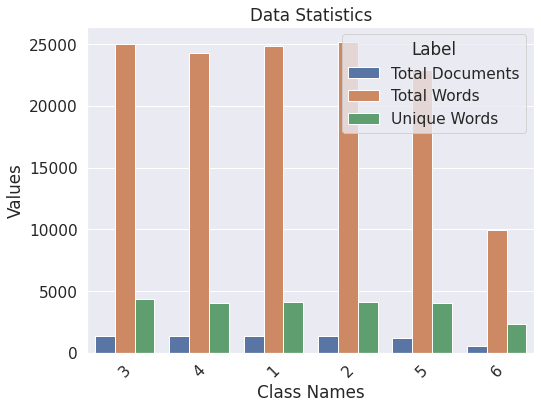

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Label", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Label')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

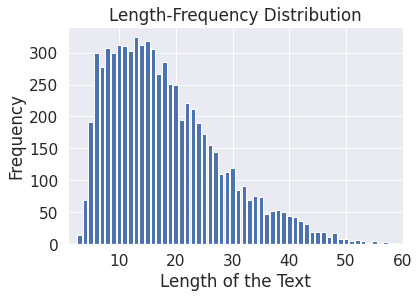

Maximum Length of a Text: 59
Minimum Length of a Text: 3
Average Length of a Text: 18.0


In [ ]:
# Calculate the Review of each of the Review
dataset['TextLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 60)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Text')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")

In [ ]:
#==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(Label,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        Label: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(Label)
    encoded_labels = le.transform(Label)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(Label[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #===========================================================

def dataset_split(Text,Label):
    """
    This function will return the splitted (90%-10%-10%) feature vector .

    Args:
        Text: sequenced Text
        Label: encoded lables (array)

    Returns:
        X_train: training data
        X_valid: validation data
        X_test : testing feature vector
        y_train: training encoded labels (array)
        y_valid: training encoded labels (array)
        y_test : testing encoded labels (array)
    """

    X,X_test,y,y_test = train_test_split(Text,Label,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(Text),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [ ]:
labels = label_encoding(dataset.Label,True)


			===== Label Encoding ===== 
Class Names:--> [1 2 3 4 5 6]
2   1 

3   2 

4   3 

6   5 

5   4 

5   4 



In [ ]:
print(labels)

[0 1 2 ... 2 2 1]


In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.Text,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 7214 
	Training		 5193 
	Test			 722 
	Validation		 1299


In [ ]:
vocab_size = 57000
embedding_dim = 64
max_length = 59
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def padded_headlines(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")
  print(original,"\n",encoded)
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)

In [ ]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
#============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
আমি 	 7835
এবং 	 2974
করি 	 2676
আমার 	 2615
বোধ 	 2489
যে 	 1738
না 	 1404
অনুভব 	 1297
করছি 	 1174
মনে 	 1169

Words --> Documents:
আমি 	 4907
বোধ 	 2400
করি 	 2265
এবং 	 2214
আমার 	 1901
যে 	 1437
অনুভব 	 1252
না 	 1175
করছি 	 1110
মনে 	 1090

Words --> Index:
পুরুষত্বের 	 9947
পুরুষকে 	 9946
ক্ষমতাহীনতায় 	 9945
দুর্বলতার 	 9944
বহিরাগতের 	 9943
ধারাবাহিকতা 	 9942
আশীর্বাদগুলির 	 9941
জলপানো 	 9940
পৌঁছাব 	 9939
চড় 	 9938

Total Documents --> 5193
Found 9947 unique tokens


In [ ]:
padded_headlines(X_train[398],train_sequences[10],train_padded[10])


			====== Encoded Sequences ====== 

এমনকি আমি আবার সাধারণ মানুষের সাথে অদ্ভুত জীবনযাপনও বোধ করি 
 [2, 218, 2864, 40, 133, 3, 160, 58, 8, 1106, 35, 59, 42, 1585, 10]

			====== Paded Sequences ======
 এমনকি আমি আবার সাধারণ মানুষের সাথে অদ্ভুত জীবনযাপনও বোধ করি 
 [   2  218 2864   40  133    3  160   58    8 1106   35   59   42 1585
   10    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [ ]:
print(X_test[354:364])

6170    আমি মারিয়ার চুম্বনের ভিডিওটি দেখেছি এবং আশ্চর...
4976    আমি মাঝে মাঝে উদার বোধ করি এবং পাখিদের এই সঞ্চ...
5378    আমি শীত পছন্দ করি তাই আমার খুশী হওয়া উচিত তবে...
5912    আমি সাধারণ বিষয়টিতে আনন্দ সন্ধানের জন্য কাজ ক...
3037    আমি এই ফ্ল্যাশব্যাক শুক্রবার এন্ট্রি সম্পর্কে ...
5889    আমি মনে করি হঠাৎ কোনও ভাল জিনিস দেখে ভয় পেয়ে...
3132    আমি বোধ করি আমি আমার বুদ্ধি থেকে আমার প্রবৃত্ত...
1140    আমি তাত্ক্ষণিকভাবে গ্ল্যামারাস বোধ করি কেবল এট...
6698    আমার মনে হয় আমি যখন স্ক্যাড ছেড়ে চলে গেলাম অ...
2948    আমি মনে করি যে মোমযুক্ত চাঁদের জন্য আমি এটি কর...
Name: Text, dtype: object


In [ ]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_valid[5608],validation_sequences[1],validation_padded[1])


			====== Encoded Sequences ====== 

আমি ভেবেছিলাম তিনি না বলতে যাচ্ছেন তবে তিনি কেবল তাঁর মুখের কুকুরছানাটিকে আমি যা বলি তা দিয়েছিল এবং এটি আমাকে সর্বদা পচা অনুভব করে makes 
 [2, 124, 1, 84, 8600, 95, 93, 1400]

			====== Paded Sequences ======
 আমি ভেবেছিলাম তিনি না বলতে যাচ্ছেন তবে তিনি কেবল তাঁর মুখের কুকুরছানাটিকে আমি যা বলি তা দিয়েছিল এবং এটি আমাকে সর্বদা পচা অনুভব করে makes 
 [   2  124    1   84 8600   95   93 1400    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [ ]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_test[444],test_sequences[100],test_padded[100])


			====== Encoded Sequences ====== 

আমি গত সপ্তাহে প্রতি রাতে ভয়ঙ্কর উদ্বেগের স্বপ্ন দেখেছিলাম এবং এটি আমাকে সত্যই বেহাল মনে করেছে এবং অবশ্যই ষড়যন্ত্রের তত্ত্বগুলি এবং অনাবিলিত অপরাধগুলি সম্পর্কে অনলাইনে পড়া সমস্ত বিষয়কে ব্যাপকভাবে সহায়তা করে নি 
 [2, 39, 1083, 27, 1887, 6, 10]

			====== Paded Sequences ======
 আমি গত সপ্তাহে প্রতি রাতে ভয়ঙ্কর উদ্বেগের স্বপ্ন দেখেছিলাম এবং এটি আমাকে সত্যই বেহাল মনে করেছে এবং অবশ্যই ষড়যন্ত্রের তত্ত্বগুলি এবং অনাবিলিত অপরাধগুলি সম্পর্কে অনলাইনে পড়া সমস্ত বিষয়কে ব্যাপকভাবে সহায়তা করে নি 
 [   2   39 1083   27 1887    6   10    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [ ]:
print(X_test)

394     আমি অধৈর্য বোধ করি তবে নিকের অনেক ধন্যবাদ তিনি...
2067    আমি গর্ভাবস্থা থেকে অনুভূতিগুলি অনুভব করতে শুর...
5721              আমি রোমান্টিক সিনেমাগুলি দেখে অনুভব করি
4986    আমি এই উদাহরণে আমি খুব স্পট বোধ করছি কিন্তু আম...
4429                           আমি খুব বিক্ষিপ্ত বোধ করছি
                              ...                        
3440    আমার এগুলির আরও কয়েকটি রয়েছে তবে আমার বাড়ির...
3277         আমি খুব নস্টালজিক এবং খুব কৃতজ্ঞ বোধ করছিলাম
4916    তিনি যিনি তার জন্য আমি তাকে পছন্দ করি বা আমার ...
5968    আমার একটা অনুভূতি আছে যদি সে স্যুপে ঝাঁপ দেয় ...
4431    আমি মনে করি শত্রুতা বা আত্মীয়তা বা বমি বমি ভা...
Name: Text, Length: 722, dtype: object


In [ ]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Bidirectional, Embedding, Dropout, Conv1D, MaxPooling1D
keras.backend.clear_session()
accuracy_threshold = 0.97
vocab_size = 57000
embedding_dim = 64
max_length = 59
num_category = 6

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint]
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(GRU(64,dropout=0.2)),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(num_category, activation='softmax')
# ])

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Dropout(.2))

model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(pool_size=4))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(.5))

model.add(Dense(66, activation="softmax"))
# opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 64)            3648000   
_________________________________________________________________
dropout (Dropout)            (None, 59, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 128)           41088     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 66)                1

In [ ]:
# !pip3 install --upgrade tensorflow

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, GRU, Bidirectional, Embedding, Dropout, Conv1D, MaxPooling1D

# keras.backend.clear_session()
# accuracy_threshold = 0.97
# vocab_size = 4809
# embedding_dim = 64
# max_length = 59
# num_category = 5

# class myCallback(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#       if(logs.get('accuracy')>accuracy_threshold):
#         print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
#         self.model.stop_training = True

# acc_callback = myCallback()
# # Saved the Best Model
# filepath = path+"Model.h5"
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
#                                              save_weights_only=False, mode='max')
# callback_list = [acc_callback, checkpoint]

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, input_length=max_length,
#                             trainable=False))
# model.add(Dropout(0.5))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=4))

# model.add(Bidirectional(GRU(100)))
# model.add(Dense(32, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(66, activation="softmax"))
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()

In [ ]:
num_epochs = 30
batch = 8
history = model.fit(train_padded, train_label_seq,
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq),
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/30
650/650 [==============================] - ETA: 0s - loss: 1.7893 - accuracy: 0.2478
Epoch 00001: val_accuracy improved from -inf to 0.39800, saving model to /content/drive/My Drive/Bangla_NLP/Model.h5
650/650 [==============================] - 25s 39ms/step - loss: 1.7893 - accuracy: 0.2478 - val_loss: 1.4396 - val_accuracy: 0.3980
Epoch 2/30
649/650 [============================>.] - ETA: 0s - loss: 1.2894 - accuracy: 0.4678
Epoch 00002: val_accuracy improved from 0.39800 to 0.54273, saving model to /content/drive/My Drive/Bangla_NLP/Model.h5
650/650 [==============================] - 23s 36ms/step - loss: 1.2895 - accuracy: 0.4677 - val_loss: 1.2674 - val_accuracy: 0.5427
Epoch 3/30
649/650 [============================>.] - ETA: 0s - loss: 0.9197 - accuracy: 0.6518
Epoch 00003: val_accuracy improved from 0.54273 to 0.57660, saving model to /content/drive/My Drive/Bangla_NLP/Model.h5
650/650 [==============================] - 23s 35ms/step - loss: 0.9197 - accuracy: 0.651

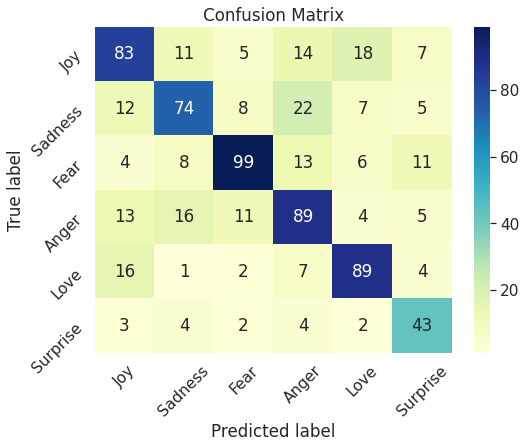

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
# model = load_model(path+"LSTM_Model.h5")
model = load_model(path+"Model.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,

                     index = ['Joy' ,'Sadness' ,'Fear', 'Anger', 'Love', 'Surprise'],
                     columns = ['Joy' ,'Sadness' ,'Fear', 'Anger', 'Love', 'Surprise'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
# plt.title('LSTM \n Test Accuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [ ]:
# 1 => 'আনন্দ'
# 2 => 'বিষণ্ণতা'
# 3 => 'ভয়'
# 4 => 'রাগ'
# 5 => 'ভালবাসা'
# 6 => 'আশ্চর্য'
# ['Joy' ,'Sadness' ,'Fear', 'Anger', 'Love', 'Surprise']

In [ ]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Joy','1':'Sadness','2':'Fear','3':'Anger','4':'Love','5':'Surprise'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Joy,63.36,60.14,61.71,138.000000
Sadness,64.91,57.81,61.16,128.000000
Fear,77.95,70.21,73.88,141.000000
Anger,59.73,64.49,62.02,138.000000
Love,70.63,74.79,72.65,119.000000
Surprise,57.33,74.14,64.66,58.000000
accuracy,66.07,66.07,66.07,0.660665
macro avg,65.65,66.93,66.01,722.000000
weighted avg,66.51,66.07,66.09,722.000000


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


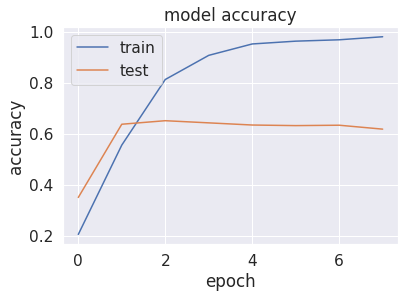

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

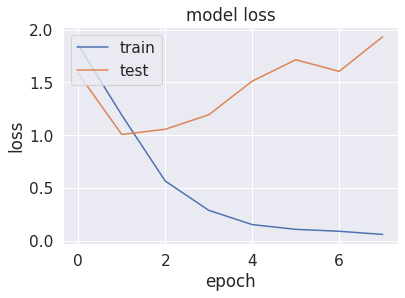

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# new_complaint = ['কাজীরাঙ্গা জাতীয় উদ্যানে আমি বাঘ দেখে ভয়ে দৌড়ে পালালাম ']
# new_complaint = ['আমি প্রচুর অসুস্থ মানুষ রয়েছি তা শুনে আমি হতবাক ও দুঃখ বোধ করি']
# new_complaint = ['ভাই হেসে তো পেটে খিল ধরে গেছে।অসাধারণ']
# new_complaint = ['আজবতো প্রশ্ন হবে ফাঁস আর সাধারণ জনগণ খাবে বাঁশ? প্রশ্ন ফাঁস নিয়ে চরম একটি']
# new_complaint = ['আমি বরং পচা বোধ করছি তাই এখনই খুব উচ্চাকাঙ্ক্ষী নই']
# new_complaint = ['পুরাই অস্থির']
# new_complaint = ['ভিডিওটা দিয়ে কি বুঝাতে চেয়েছে কেউ একটু বলবেন']
# new_complaint = ['আমি এখনই খুব অসন্তুষ্ট বোধ করছি']
new_complaint = ['আমি এমন কিছু সম্পর্কে উত্তেজিত বোধ করি যা কেবলমাত্র আমার পক্ষে এটির ভিডিও এখানে']

seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['Joy' ,'Sadness' ,'Fear', 'Anger', 'Love', 'Surprise']
print(pred, labels[np.argmax(pred)])

[[0.01162412 0.00508614 0.08827238 0.06343586 0.01941759 0.8121639 ]] Surprise


In [ ]:
print(model)

In [ ]:
print(X_test[394])
print(test_padded)

আমি কেবল ফিরে ভাবছি এবং পুরোপুরি অবাক এবং কৃতজ্ঞতা বোধ করছি যে আমরা এমন এক সময়ে বাস করি যখন চার পরিবারের জন্য প্রয়োজন চারজন মানুষ হাজার মাইল দূরে থাকার পরেও একে অপরকে খুঁজে পেতে পারে
[[   2   37  127 ...    0    0    0]
 [   2  123    4 ...    0    0    0]
 [   2  158  107 ...    0    0    0]
 ...
 [   2    5    1 ...    0    0    0]
 [   2  751 1533 ...    0    0    0]
 [   2   37  654 ...    0    0    0]]


In [ ]:
model = load_model(path+"Model.h5")
# model = load_model("Model.h5")
predictions = model.predict(test_padded[354:364])
y_pred = np.argmax(predictions, axis=1)
print(y_pred)
temp_y_pred = y_pred

[3 4 3 0 4 2 3 0 5 0]


In [ ]:
print(testing_label_seq[354:364])
temp_testing_label_seq = testing_label_seq[354:364]

[1 4 1 0 4 2 0 0 5 0]


In [ ]:
print("test data", " ", "Predicted Label", "True Label")
index = ['Joy' ,'Sadness' ,'Fear', 'Anger', 'Love', 'Surprise']
test_result = {"test_sentence": [], "p_label": [], "T_label": []}
for i in X_test[354:364]:
  test_result["test_sentence"].append(i)
for i in temp_y_pred:
  test_result["p_label"].append(index[i])
for j in temp_testing_label_seq:
  test_result["T_label"].append(index[j])
pd.DataFrame.from_dict(test_result).to_csv(path+"bigru_test_result.csv", index= False)

test data   Predicted Label True Label


In [ ]:
print(test_result)

{'test_sentence': ['আমি মারিয়ার চুম্বনের ভিডিওটি দেখেছি এবং আশ্চর্যরূপে আমার মনে হয় না যে আমি তাকে ঘৃণা করি', 'আমি মাঝে মাঝে উদার বোধ করি এবং পাখিদের এই সঞ্চয়গুলির কিছুটা খাওয়াই', 'আমি শীত পছন্দ করি তাই আমার খুশী হওয়া উচিত তবে আমি বিষণ্ন ও হতাশাবোধ করতে পারি না', 'আমি সাধারণ বিষয়টিতে আনন্দ সন্ধানের জন্য কাজ করার চেষ্টা করছি যে myশ্বর তাঁর প্রতি আমার আনুগত্যে আনন্দ পাচ্ছেন এমনকি যদিও আমি যেভাবে অভ্যস্ত হয়েছি তাতে সে খুব আনন্দ বোধ করে না', 'আমি এই ফ্ল্যাশব্যাক শুক্রবার এন্ট্রি সম্পর্কে কিছুটা উদাসীন অনুভূতি বোধ করছি কারণ আমি বুঝতে পারি যে আজ বিভিন্ন জিনিসগুলি কেমন', 'আমি মনে করি হঠাৎ কোনও ভাল জিনিস দেখে ভয় পেয়েছি এবং এটি এখনই নাশকতা করছে এবং আমি যদি তাকে স্থান দান করি তবে জাহান্নাম ফিরে আসবে তবে আমার মনে হয় হিঙ্কার এত জায়গা ছিল এবং এখনও তার যথেষ্ট মনে হচ্ছে না', 'আমি বোধ করি আমি আমার বুদ্ধি থেকে আমার প্রবৃত্তির উপর নির্ভর করতে পারি তবে আমার অনুভূতি যেমন হওয়া উচিত ততই আগ্রহী কিনা তা নিয়ে সন্দেহ শুরু করছি', 'আমি তাত্ক্ষণিকভাবে গ্ল্যামারাস বোধ করি কেবল এটি আমার হ্যান্ডব্যাগ থেক

In [ ]:
temp_x_test = ['আমি তার মৃত্যু দেখে মন খারাপ করেছিলাম',
               'আমি পরীক্ষায় ফেল করার পরে মন খারাপ করেছিলাম',
               'আমি বাঘ দেখে ভয় পেয়েছি',
               'আমি তার কাজ দেখে অবাক হয়েছি',
               'মানবতার কাজে নিয়োজিত ব্যাক্তিদের আমি মন থেকে ভালবাসি',
               'আমি তোমায় ভালোবাসি',
               'চিড়িয়াখানায় গিয়ে আমি খুশি হয়েছিলাম',
               'আমি এই মুহুর্তে নিরাপত্তাহীন বোধ করছি',
               'সে জোরে হাসছিল কার্টুনটি দেখে',
               'আমি আজ একটু স্বাচ্ছন্দ্য বোধ করছি',
               'করোনায় পরিস্থিতিতে মানুষের আকস্মিক  দুদর্শা দেখে আমি বেশ ব্যথিত',
               'আমি সাপ দেখে ভয় পেয়েছি',
               'আমি তার খারাপ ব্যবহারের জন্য রেগে গেছি',
               'মেসির ফ্রিকিক গোল দেখে আমি অবাক হয়ে গেলাম',
               'মীরের অভিনয়ে দেখে আমি প্রায়শই আট্ট হাসি দেই',
               'আমি তোমায় দেখে মুগ্ধ হয়েছি']
temp_testing_label_seq = [1, 1, 2, 5, 4, 4, 0, 2, 0, 0, 1, 2, 3, 5, 0,5]

In [ ]:
# Test Data Tokenization
temp_test_sequences = tokenizer.texts_to_sequences(temp_x_test)
temp_test_padded = pad_sequences(temp_test_sequences, padding=padding_type , maxlen=59)
# temp_padded_headlines(X_test[444],temp_test_sequences[100],test_padded[100])

In [ ]:
model = load_model(path+"Model.h5")
# model = load_model("Model.h5")
predictions = model.predict(temp_test_padded)
temp_y_pred = np.argmax(predictions, axis=1)

In [ ]:
index = ['Joy' ,'Sadness' ,'Fear', 'Anger', 'Love', 'Surprise']
test_result = {"test_sentence": [], "p_label": [], "T_label": []}
error = 0
for i in temp_x_test:
  test_result["test_sentence"].append(i)
# for i in temp_y_pred:
#   test_result["p_label"].append(index[i])
# for j in temp_testing_label_seq:
#   test_result["T_label"].append(index[j])
for i in range(len(temp_y_pred)):
  if temp_y_pred[i] != temp_testing_label_seq[i]:
    test_result["T_label"].append(str(index[temp_testing_label_seq[i]])+" "+str(error))
    test_result["p_label"].append(str(index[temp_y_pred[i]]) + " "+str(error))
    error += 1
  else:
    test_result["T_label"].append(index[temp_testing_label_seq[i]])
    test_result["p_label"].append(index[temp_y_pred[i]])
df = pd.DataFrame.from_dict(test_result)
print(df)
print(error)
df.to_csv(path+"lstm_test_result.csv", index= False)

                                        test_sentence     p_label    T_label
0               আমি তার মৃত্যু দেখে মন খারাপ করেছিলাম     Anger 0  Sadness 0
1        আমি পরীক্ষায় ফেল করার পরে মন খারাপ করেছিলাম     Anger 1  Sadness 1
2                            আমি বাঘ দেখে ভয় পেয়েছি        Fear       Fear
3                        আমি তার কাজ দেখে অবাক হয়েছি    Surprise   Surprise
4   মানবতার কাজে নিয়োজিত ব্যাক্তিদের আমি মন থেকে ভ...        Love       Love
5                                 আমি তোমায় ভালোবাসি        Love       Love
6             চিড়িয়াখানায় গিয়ে আমি খুশি হয়েছিলাম         Joy        Joy
7               আমি এই মুহুর্তে নিরাপত্তাহীন বোধ করছি        Fear       Fear
8                       সে জোরে হাসছিল কার্টুনটি দেখে  Surprise 2      Joy 2
9                   আমি আজ একটু স্বাচ্ছন্দ্য বোধ করছি         Joy        Joy
10  করোনায় পরিস্থিতিতে মানুষের আকস্মিক  দুদর্শা দে...      Fear 3  Sadness 3
11                           আমি সাপ দেখে ভয় পেয়েছি        Fear       Fear

In [ ]:
f1_score(temp_testing_label_seq, temp_y_pred, average='macro')

0.628968253968254

In [ ]:
f1_score(temp_testing_label_seq, temp_y_pred, average='weighted')

0.6242559523809523

In [ ]:
f1_score(temp_testing_label_seq, temp_y_pred, average=None)

array([0.66666667, 0.        , 0.85714286, 0.5       , 1.        ,
       0.75      ])